# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Компьютерное зрение & генеративные модели


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 150 баллов
* Задача 2 &mdash; 40 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [3]:
!pip install torchinfo

In [4]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchinfo

from IPython.display import clear_output
sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_1.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_classification.html" target="_blank">ноутбук</a> про сверточные сети и классификацию, а так же <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_2.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">ноутбук</a> про перенос стиля и генеративные сети.

---
### Задача 1. Классификация MNIST


Цель: сравнить сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Пользоваться кодом семинара можно без ограничений. Классификация MNIST намного легче, чем CIFAR, поэтому ваша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

> Использования слоев с семинара (свертка, pooling) более чем достаточно для достижения 98% точности на тесте. Также не делайте сеть глубокой.

> Тестируйте работоспособность кода на CPU с небольшим кол-вом итераций. Если все работает, и хочется ускорить процесс, переходите на GPU.

Следуйте указаниям ниже.

Загрузим датаcет из `torchvision.datasets`.

In [ ]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True,
                                           transform=transforms.ToTensor())
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True,
                                         transform=transforms.ToTensor())
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

100%|██████████| 9912422/9912422 [00:00<00:00, 65339589.13it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 111851979.52it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32148245.89it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4105717.41it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Визуализируйте несколько картинок с соответствующими метками из датасета.

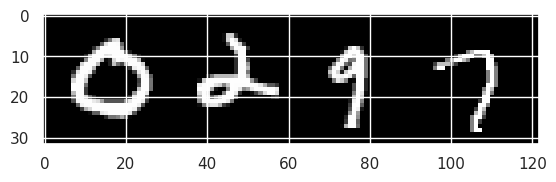

    0     2     9     7


In [ ]:
# Функция для отображения изображений из датасета
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# выберем случайные индексы для изображений
indices = np.random.choice(len(train_dataset), 4)
images = torch.stack([train_dataset[i][0] for i in indices])
labels = [train_dataset[i][1] for i in indices]

# показать изображения
imshow(torchvision.utils.make_grid(images))
# Вывести метки
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Создайте генераторы батчей.

In [ ]:
# Задаем размер батча
batch_size = 64

# Создаём генераторы батчей для тренировочного и валидационного наборов
train_batch_gen = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch_gen = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# Проверим количество батчей в каждом генераторе
print(f"Количество батчей в train_loader: {len(train_batch_gen)}")
print(f"Количество батчей в val_loader: {len(val_batch_gen)}")

Количество батчей в train_loader: 938
Количество батчей в val_loader: 157


**Эксперимент 1.** Создайте хотя бы 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Должен присутствовать хотя бы 1 сверточный слой и хотя бы 1 линейный слой. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

In [ ]:
# Модель 1: Один сверточный слой и один линейный слой
class SimpleCNN1(nn.Module):
    def __init__(self):
        super(SimpleCNN1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(16 * 28 * 28, 10),
        )

    def forward(self, x):
        x = self.layer1(x)
        return x

# Создаем экземпляр модели
model1 = SimpleCNN1().to(device)

# Выводим информацию о модели
torchinfo.summary(model1, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN1                               [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 16, 28, 28]           160
│    └─ReLU: 2-2                         [1, 16, 28, 28]           --
│    └─Flatten: 2-3                      [1, 12544]                --
│    └─Linear: 2-4                       [1, 10]                   125,450
Total params: 125,610
Trainable params: 125,610
Non-trainable params: 0
Total mult-adds (M): 0.25
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.50
Estimated Total Size (MB): 0.61

In [ ]:
# Модель 2: Два сверточных слоя и два линейных слоя с ReLU
class SimpleCNN2(nn.Module):
    def __init__(self):
        super(SimpleCNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 24, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(24 * 28 * 28, 32)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(32, 10)
        self.relu4 = nn.ReLU()
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.relu4(x)
        return x

model2 = SimpleCNN2().to(device)
torchinfo.summary(model2, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN2                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 8, 28, 28]            80
├─ReLU: 1-2                              [1, 8, 28, 28]            --
├─Conv2d: 1-3                            [1, 24, 28, 28]           1,752
├─ReLU: 1-4                              [1, 24, 28, 28]           --
├─Flatten: 1-5                           [1, 18816]                --
├─Linear: 1-6                            [1, 32]                   602,144
├─ReLU: 1-7                              [1, 32]                   --
├─Linear: 1-8                            [1, 10]                   330
├─ReLU: 1-9                              [1, 10]                   --
Total params: 604,306
Trainable params: 604,306
Non-trainable params: 0
Total mult-adds (M): 2.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 2.42
Estimated Total Size (MB): 2.62

In [ ]:
# Модель 3: Три сверточных слоя и 1 линейных слоя с ReLU
class SimpleCNN3(nn.Module):
    def __init__(self):
        super(SimpleCNN3, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 28 * 28, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

model3 = SimpleCNN3()
torchinfo.summary(model3, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN3                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 8, 28, 28]            80
├─ReLU: 1-2                              [1, 8, 28, 28]            --
├─Conv2d: 1-3                            [1, 16, 28, 28]           1,168
├─ReLU: 1-4                              [1, 16, 28, 28]           --
├─Conv2d: 1-5                            [1, 32, 28, 28]           4,640
├─ReLU: 1-6                              [1, 32, 28, 28]           --
├─Flatten: 1-7                           [1, 25088]                --
├─Linear: 1-8                            [1, 10]                   250,890
Total params: 256,778
Trainable params: 256,778
Non-trainable params: 0
Total mult-adds (M): 4.87
Input size (MB): 0.00
Forward/backward pass size (MB): 0.35
Params size (MB): 1.03
Estimated Total Size (MB): 1.38

In [ ]:
# Модель 4: Два сверточных слоя и один линейный слой с ReLU
class SimpleCNN4(nn.Module):
    def __init__(self):
        super(SimpleCNN4, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(64 * 28 * 28, 10)  # Corrected input size
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

model4 = SimpleCNN4().to(device)
torchinfo.summary(model4, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN4                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─ReLU: 1-2                              [1, 32, 28, 28]           --
├─Conv2d: 1-3                            [1, 64, 28, 28]           18,496
├─ReLU: 1-4                              [1, 64, 28, 28]           --
├─Flatten: 1-5                           [1, 50176]                --
├─Linear: 1-6                            [1, 10]                   501,770
Total params: 520,586
Trainable params: 520,586
Non-trainable params: 0
Total mult-adds (M): 15.25
Input size (MB): 0.00
Forward/backward pass size (MB): 0.60
Params size (MB): 2.08
Estimated Total Size (MB): 2.69

In [ ]:
# Модель 5: Один сверточный слой и два линейных слоя с ReLU
class SimpleCNN5(nn.Module):
    def __init__(self):
        super(SimpleCNN5, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 28 * 28, 64)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(64, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu2(x)
        x = self.fc2(x)
        return x

model5 = SimpleCNN5().to(device)
torchinfo.summary(model5, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN5                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─ReLU: 1-2                              [1, 32, 28, 28]           --
├─Flatten: 1-3                           [1, 25088]                --
├─Linear: 1-4                            [1, 64]                   1,605,696
├─ReLU: 1-5                              [1, 64]                   --
├─Linear: 1-6                            [1, 10]                   650
Total params: 1,606,666
Trainable params: 1,606,666
Non-trainable params: 0
Total mult-adds (M): 1.86
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 6.43
Estimated Total Size (MB): 6.63

Обучите сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

In [ ]:
learning_rate = 0.01

Код из семинара для обучения модели

In [ ]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(
    X_batch, y_batch, model, criterion, current_loss, current_acc
):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc

def train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(
            history, train_loss, train_acc, len(train_batch_gen), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr=learning_rate)

history_model1 = train(
    model1,
    criterion,
    optimizer1,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
)
# Сохраняем веса модели в файл
torch.save(model1.state_dict(), "model1.pth")

Epoch 10 of 10 took 8.632 s
  training loss: 	0.018257
  validation loss: 	0.140083
  training accuracy: 			99.37 %
  validation accuracy: 			97.76 %


In [ ]:
optimizer2 = torch.optim.Adam(model2.parameters(), lr=learning_rate)

history_model2 = train(
    model2,
    criterion,
    optimizer2,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
)
# Сохраняем веса модели в файл
torch.save(model2.state_dict(), "model2.pth")

Epoch 10 of 10 took 10.335 s
  training loss: 	0.530090
  validation loss: 	0.590350
  training accuracy: 			77.92 %
  validation accuracy: 			76.96 %


In [ ]:
optimizer3 = torch.optim.Adam(model3.parameters(), lr=learning_rate)

history_model3 = train(
    model3,
    criterion,
    optimizer3,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
)
# Сохраняем веса модели в файл
torch.save(model3.state_dict(), "model3.pth")

Epoch 10 of 10 took 9.838 s
  training loss: 	0.039000
  validation loss: 	0.123941
  training accuracy: 			98.83 %
  validation accuracy: 			97.24 %


In [ ]:
optimizer4 = torch.optim.Adam(model4.parameters(), lr=learning_rate)

history_model4 = train(
    model4,
    criterion,
    optimizer4,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
)
# Сохраняем веса модели в файл
torch.save(model4.state_dict(), "model4.pth")

Epoch 10 of 10 took 10.542 s
  training loss: 	0.039459
  validation loss: 	0.120945
  training accuracy: 			98.77 %
  validation accuracy: 			97.18 %


In [ ]:
optimizer5 = torch.optim.Adam(model5.parameters(), lr=learning_rate)

history_model5 = train(
    model5,
    criterion,
    optimizer5,
    train_batch_gen,
    val_batch_gen,
    num_epochs=10,
)
# Сохраняем веса модели в файл
torch.save(model5.state_dict(), "model5.pth")

Epoch 10 of 10 took 9.497 s
  training loss: 	0.023387
  validation loss: 	0.190898
  training accuracy: 			99.44 %
  validation accuracy: 			97.67 %


Постройте график лосса и график accuracy, где сравниваются все модели (на train и на val). Нужная функция есть в семинаре.

In [ ]:
def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown", "yellow"]
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(
            history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(
            history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

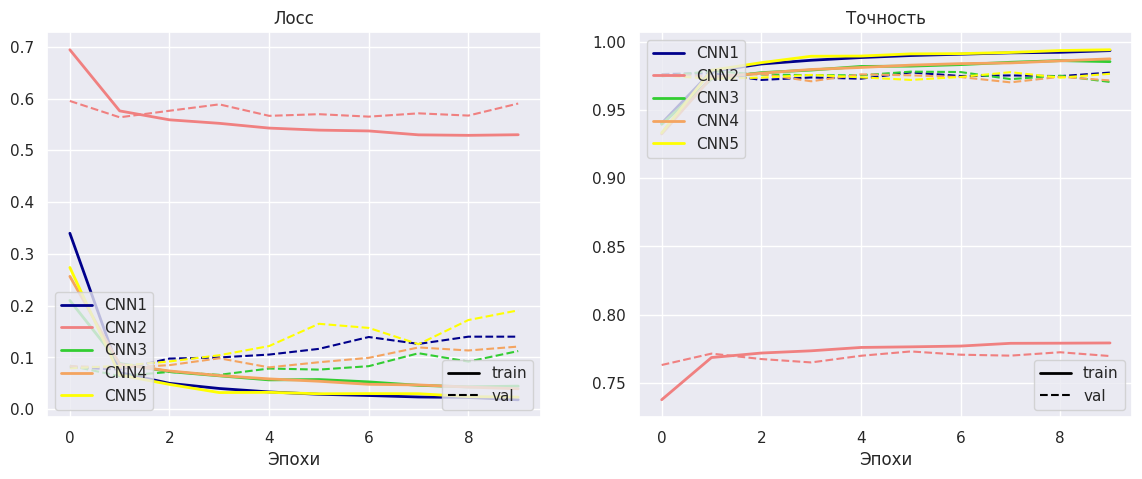

In [ ]:

plot_histories([history_model1, history_model2, history_model3, history_model4, history_model5], ["CNN1", "CNN2", "CNN3", "CNN4", "CNN5"])


Сделайте вывод. Как количество разных слоев влияет на качество и время обучения?

**Вывод по эксперименту 1:** Из данной части эксперимента, мы можем увидеть что при 2 линейных слоях и 2 сверточных качество предсказаний заметно хуже, с другой стороны уменьшив количество линейных слоев и увеличив сверточных до 3-х дало нам нейросеть которая предсказывает лучше остальных. Отсюда можно понять, что для данной задачи классификации увеличение количества линейных слоев может ухудшить модель для предсказаний

**Эксперимент 2.** Теперь выберите лучший вариант, зафиксируйте это количество сверточных и линейных слоев и обучите хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток. Например, в разном порядке поставьте ядра 3x3, 5x5.

Так как в предыдущем эксперименте лучше всего себя проявила 3-я нейронка, то тут я выбираю её. Хочу посмотреть как она себя ведет в зависимости от ядер и для этого рассматриваю следующие модели

In [ ]:
# Модель с ядрами 3x3, 3x3, 3x3
class BestCNN_3x3(nn.Module):
    def __init__(self):
        super(BestCNN_3x3, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 28 * 28, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

# Модель с ядрами 5x5, 3x3, 3x3
class BestCNN_5x5_3x3_3x3(nn.Module):
    def __init__(self):
        super(BestCNN_5x5_3x3_3x3, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 5, padding=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 28 * 28, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

# Модель с ядрами 3x3, 5x5, 3x3
class BestCNN_3x3_5x5_3x3(nn.Module):
    def __init__(self):
        super(BestCNN_3x3_5x5_3x3, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, 5, padding=2)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 28 * 28, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

# Модель с ядрами 3x3, 3x3, 5x5
class BestCNN_3x3_3x3_5x5(nn.Module):
    def __init__(self):
        super(BestCNN_3x3_3x3_5x5, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(16, 32, 5, padding=2)
        self.relu3 = nn.ReLU()
        self.fc1 = nn.Linear(32 * 28 * 28, 10)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x



In [ ]:
# Создадим четыре модели с разными размерами ядер сверток
bestmodel1 = BestCNN_3x3().to(device)
bestmodel2 = BestCNN_5x5_3x3_3x3().to(device)
bestmodel3 = BestCNN_3x3_5x5_3x3().to(device)
bestmodel4 = BestCNN_3x3_3x3_5x5().to(device)

# Обучим каждую модель
bestoptimizer1 = torch.optim.Adam(bestmodel1.parameters(), lr=learning_rate)
best_history_1 = train(
      bestmodel1,
      criterion,
      bestoptimizer1,
      train_batch_gen,
      val_batch_gen,
      num_epochs=10,
      )


Epoch 10 of 10 took 11.299 s
  training loss: 	0.044166
  validation loss: 	0.119813
  training accuracy: 			98.81 %
  validation accuracy: 			97.50 %


In [ ]:
bestoptimizer2 = torch.optim.Adam(bestmodel2.parameters(), lr=learning_rate)
best_history_2 = train(
      bestmodel2,
      criterion,
      bestoptimizer2,
      train_batch_gen,
      val_batch_gen,
      num_epochs=10,
      )

Epoch 10 of 10 took 10.665 s
  training loss: 	0.042069
  validation loss: 	0.083882
  training accuracy: 			98.75 %
  validation accuracy: 			98.04 %


In [ ]:
bestoptimizer3 = torch.optim.Adam(bestmodel3.parameters(), lr=learning_rate)
best_history_3 = train(
      bestmodel3,
      criterion,
      bestoptimizer3,
      train_batch_gen,
      val_batch_gen,
      num_epochs=10,
      )

Epoch 10 of 10 took 10.528 s
  training loss: 	0.033989
  validation loss: 	0.125675
  training accuracy: 			99.03 %
  validation accuracy: 			97.66 %


In [ ]:
bestoptimizer4 = torch.optim.Adam(bestmodel4.parameters(), lr=learning_rate)
best_history_4 = train(
      bestmodel4,
      criterion,
      bestoptimizer4,
      train_batch_gen,
      val_batch_gen,
      num_epochs=10,
      )

Epoch 10 of 10 took 10.122 s
  training loss: 	0.036503
  validation loss: 	0.109285
  training accuracy: 			98.79 %
  validation accuracy: 			97.61 %


Постройте график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

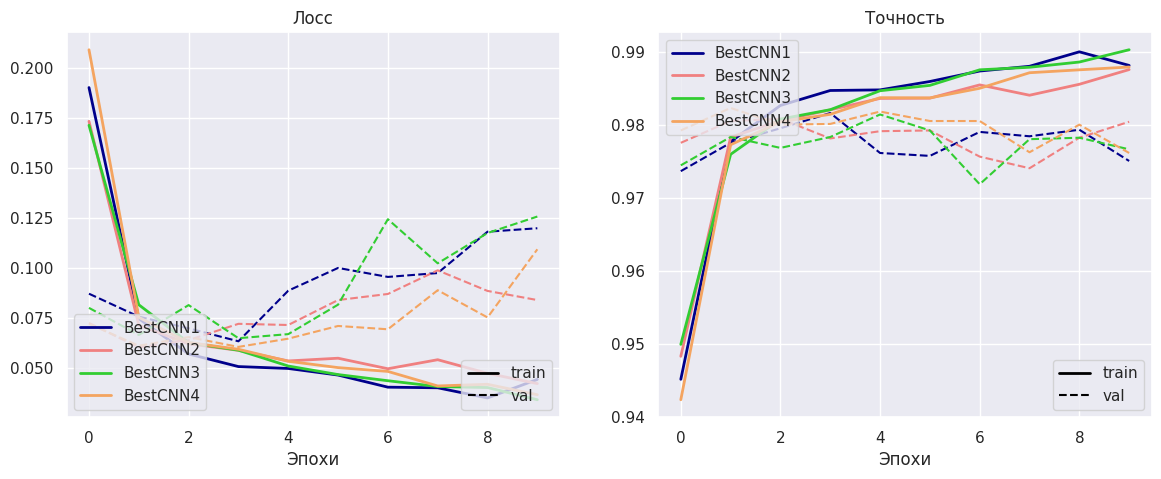

In [ ]:

plot_histories([best_history_1, best_history_2, best_history_3, best_history_4], ["BestCNN1", "BestCNN2", "BestCNN3", "BestCNN4"])


Сделайте вывод. Как размеры ядер влияют на качество и время обучения?

**Вывод по эксперименту 2:** Проведенный эксперимент и графики выше говорят о том, что при использование ядра большей размерности для более поздних сверточных слоев при дальнейшем обучении моделей ухудшает показатель loss, что может быть связано с тем что картины в нашем наборе простые и при поиске паттернов на последних слоях свертки "засоряется мусорной информацией" 

**Анализ лучшей модели.** Выберите лучшую конфигурацию из всех по accuracy на валидации. Она должна быть не меньше 98%.

**Обоснование выбора:** При локальном запуске моделей, у меня bestmodel3 выдавало больше 98%, и для большего количества эпох я решил перейти на коллаб в котором у меня ни одна не превосходит 98% (может быть это связано именно со средой для запуска кода), но тем не менее bestmodel2 даёт очень близко к тому что нам надо и по этому далее я возьму её как лучшую модель

Проведите еще один проход валидации выбранной моделью по всему датасету. В нем посчитайте точность по каждому классу и соберите информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажите 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

In [ ]:
not_correct_pred = []
accuracy = np.zeros(10)
bestmodel2.eval()
# Контекстный менеджер, отключающий подсчет градиентов
with torch.no_grad():
    # Полный проход по валидационному датасету
    for X, y in val_batch_gen:
        X = X.to(device)
        y = y.to(device)

        log = bestmodel2(X)
        # предсказание
        y_pred = log.max(1)[1].detach().cpu().numpy()
        for num in range(10):
            if (np.sum((y.cpu().numpy() == num)) != 0):
                accuracy[num] += np.sum((y_pred == y.cpu().numpy()) & (y.cpu().numpy() == num)) / np.sum((y.cpu().numpy() == num))

        not_correct_pred.extend(X[y_pred != y.cpu().numpy()])

# делим на число батчей
accuracy = np.array(accuracy) / len(val_batch_gen)



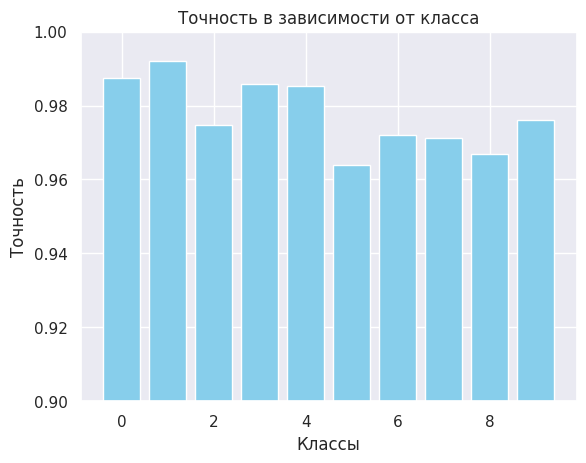

In [ ]:
# График
plt.bar(range(10), accuracy, color='skyblue')
plt.ylim((0.9, 1))
plt.title("Точность в зависимости от класса")
plt.xlabel("Классы")
plt.ylabel("Точность")
plt.show()


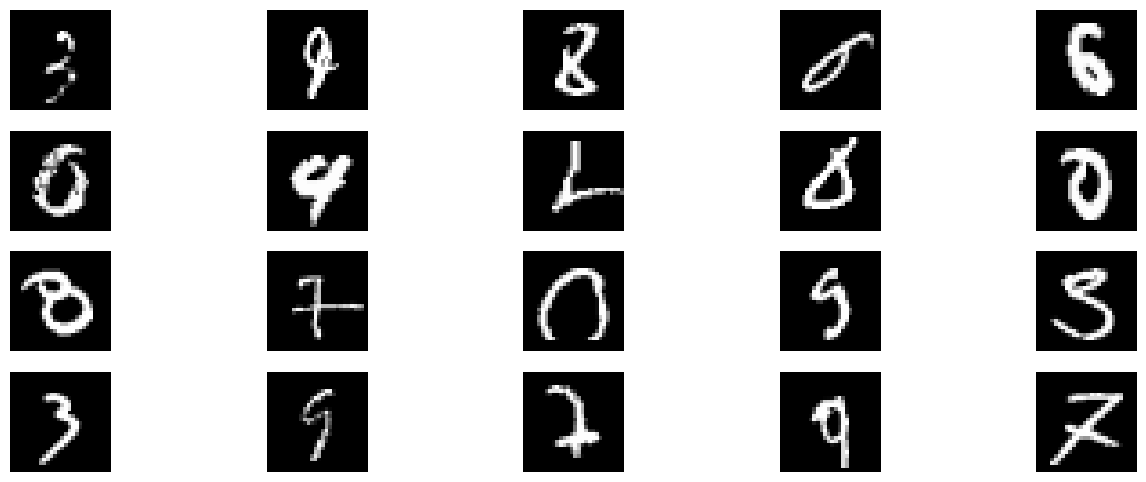

In [ ]:
#Неправильно предсказанные картинки
numbers = np.arange(len(not_correct_pred))
np.random.shuffle(numbers)

plt.figure(figsize=(16,6))
for num, img in enumerate(numbers[:20]):
    plt.subplot(4,5,num + 1)
    plt.imshow(not_correct_pred[img].cpu().permute(1,2,0), cmap='gray')
    plt.axis("off")

**Ответ:** Гистограмма с зависимостями классов и предсказаний показывает что для более сложных чисел она работает хуже (3, 5, 8) чем для более простых в написании (0, 1). Рисунок 20 неугаданных картин сверху показывает что мы не смогли это сделать для чисел в которых либо очень мало белых пикселей (картина в левом верхем углу), либо что-то очень непонятное(вторая строка третий столбец), либо когда много пикселей в одном месте находятся/отсутсвуют не характерные для данного числа (первый столбец вторая строка, вроде 0 но вроде и 6) 

**Вывод по всей задаче:** Все эти эксперименты показали что для хорошей обработки черно белых изображений цифр нейронная сеть с только сверточными и линейными слоями справляется отлично

---
### Задача 2. Перенос стиля

Здесь вы потренируетесь в работе с картинками и составлением промптов. Используя код с <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">семинара</a>, проведите перенос стиля на хотя бы 3 своих примерах.

> Заметьте, что в примерах с семинара в качестве картинок стиля и контента использовались картинки среднего разрешения. Если возникают проблемы: оптимизация останавливается на 0-й эпохе и не создает картинку; loss в какой-то момент стал nan; нехватка RAM; &mdash; то либо уменьшите разрешение ваших картинок, либо попробуйте картинку полегче.

**Код с семинара**

In [ ]:
import os
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

sns.set(palette="Set2")

In [ ]:
!git clone https://github.com/nazianafis/Neural-Style-Transfer
# Перейдем в директорию скачанного репозитория
%cd /content/Neural-Style-Transfer/

# Небольшая обработка скрипта, не менять!
file_path = "NST.py"
with open(file_path, "r") as file:
    # Убираем автоматический запуск
    lines = file.readlines()[:183]
# Вывод логов только каждые 100 эпох
lines = lines[:175] + ["            if cnt % 100 == 0:\n"] + lines[175:]
lines[176] = "    " + lines[176]
with open(file_path, "w") as file:
    file.writelines(lines)

from NST import *


Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 379 (delta 72), reused 105 (delta 34), pack-reused 225
Receiving objects: 100% (379/379), 92.21 MiB | 44.12 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/Neural-Style-Transfer


In [ ]:
def run_neural_style_transfer(content_image="c1.jpg", style_image="s1.jpg"):
    """
    Функция для запуска метода Neural Style Transfer.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :return: results_path -- путь к папке, в которую сохранился результат
    """
    PATH = ""
    default_resource_dir = os.path.join(PATH, "data")
    content_images_dir = os.path.join(default_resource_dir, "content-images")
    style_images_dir = os.path.join(default_resource_dir, "style-images")
    output_img_dir = os.path.join(default_resource_dir, "output-images")
    img_format = (4, ".jpg")

    # Задаем конфиги, включая вес компонент лосса
    optimization_config = {
        "content_img_name": content_image,
        "style_img_name": style_image,
        "height": 400,
        "content_weight": 100000.0,
        "style_weight": 30000.0,
        "tv_weight": 1.0,
    }
    optimization_config["content_images_dir"] = content_images_dir
    optimization_config["style_images_dir"] = style_images_dir
    optimization_config["output_img_dir"] = output_img_dir
    optimization_config["img_format"] = img_format

    results_path = neural_style_transfer(optimization_config)
    return results_path

In [ ]:
def visualize_style_transfer(content_image, style_image, results_path):
    """
    Визуализация результатов.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :param results_path: путь к папке, в которую сохранился результат
    """
    if len(os.listdir(results_path)) == 0:
        return
    plt.figure(figsize=(13, 3))
    folders = [
        "content-images/",
        "output-images/" + Path(results_path).name + "/",
        "style-images/",
    ]
    combined_image = (
        Path(content_image).stem + "_" + Path(style_image).stem + ".jpg"
    )
    files = [content_image, combined_image, style_image]
    titles = ["Контент", "Результат", "Стиль"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread("data/" + folders[i] + files[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

In [ ]:
# подключим Google Drive
from google.colab import drive

drive.mount("/content/drive")

# пути к нужным папкам в Drive
content_path = "/content/drive/MyDrive/content"
style_path = "/content/drive/MyDrive/style"

# очистим предыдущие картинки, скопируем новые
!rm -r data/content-images
!mkdir data/content-images
!cp -a /$content_path/. data/content-images/

!rm -r data/style-images
!mkdir data/style-images
!cp -a /$style_path/. data/style-images/

Mounted at /content/drive


In [ ]:
content_images = sorted(os.listdir("data/content-images"))
style_images = sorted(os.listdir("data/style-images"))
result_paths = []
for content_image, style_image in zip(content_images, style_images):
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)



Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 62.0MB/s]


Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=1463922720768.0000, content_loss=      0.0000, style loss=1463906760000.0000, tv loss=15982883.0000
L-BFGS | iteration: 100, total loss=19066320896.0000, content_loss=2048109179.6875, style loss=16994405625.0000, tv loss=23805608.0000
L-BFGS | iteration: 200, total loss=8564937216.0000, content_loss=2110312890.6250, style loss=6429809531.2500, tv loss=24814436.0000
L-BFGS | iteration: 300, total loss=6281392128.0000, content_loss=2089148437.5000, style loss=4166892656.2500, tv loss=25351028.0000
L-BFGS | iteration: 400, total loss=5334821888.0000, content_loss=2068112695.3125, style loss=3240758203.1250, tv loss=25951324.0000
L-BFGS | iteration: 500, total loss=4838093312.0000, content_loss=2050060546.8750, style loss=2761541250.0000, tv loss=26491464.0000
L-BFGS | iteration: 600, total loss=4541676544.0000, content_loss=2035949023.4375, style loss=2478738984.3750, tv loss=26988360.0000
L-BFGS | iteration: 7

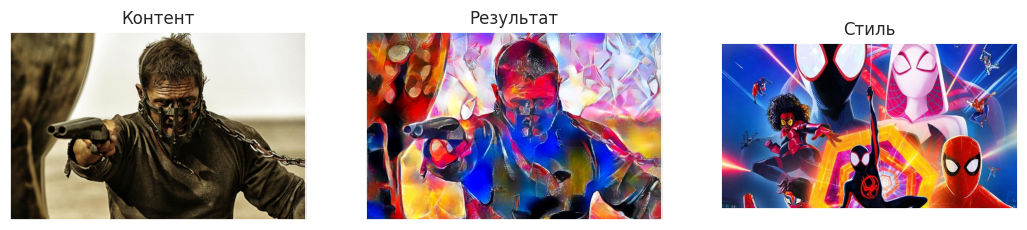

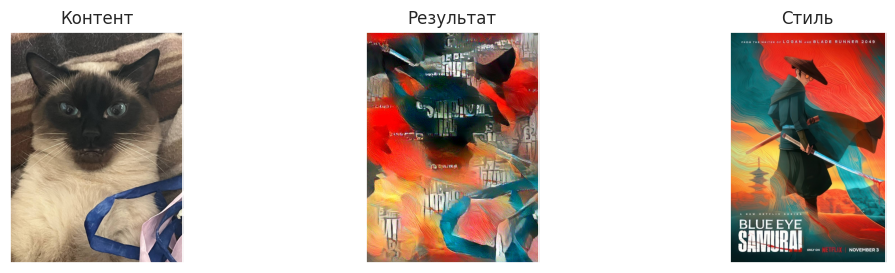

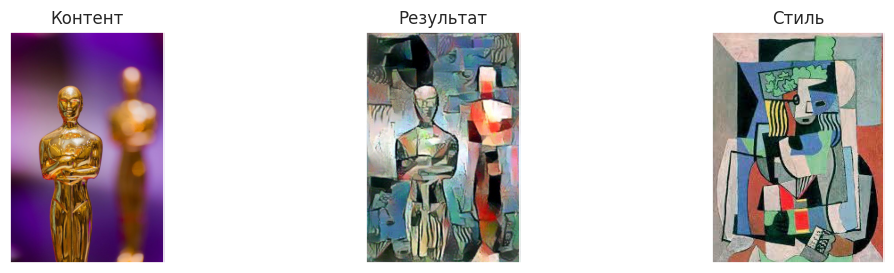

In [ ]:
# Сохраним результаты
!cp -r data/output-images /content/drive/MyDrive/

# Визуализируем
for content_image, style_image, results_path in zip(
    content_images, style_images, result_paths
):
    visualize_style_transfer(content_image, style_image, results_path)

Теперь для каждой пары контекст-стиль попытайтесь сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

**Снова копируем код с семинарского ноутбука**

In [2]:
!pip install -q diffusers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 8.7 MB/s eta 0:00:00


In [1]:
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

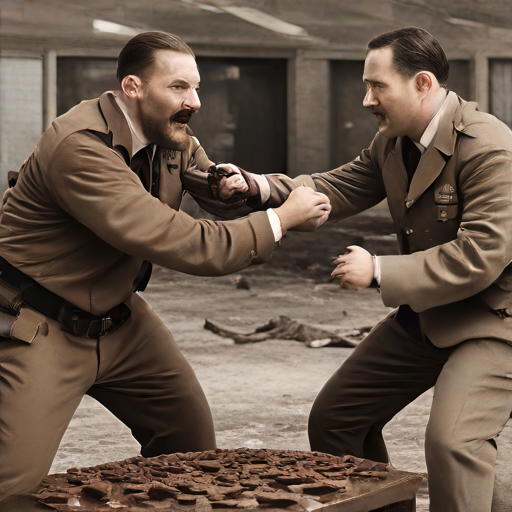

In [3]:
prompt1 = "Tom Hardy fighting with chocolate Hitler"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image1 = pipe(prompt=prompt1, num_inference_steps=1, guidance_scale=0.0).images[0]
image1



  0%|          | 0/1 [00:00<?, ?it/s]

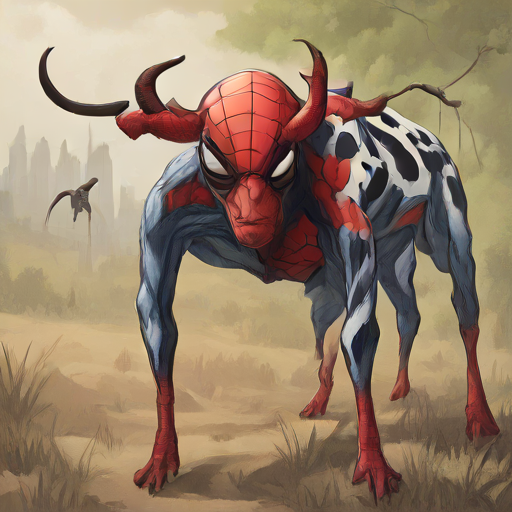

In [4]:
prompt2 = "Spider man from universe of animals, cow"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image2 = pipe(prompt=prompt2, num_inference_steps=1, guidance_scale=0.0).images[0]
image2

  0%|          | 0/1 [00:00<?, ?it/s]

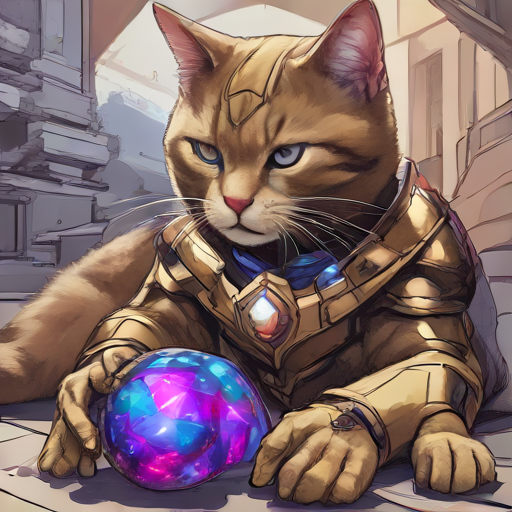

In [6]:
prompt3 = "Cat that collected all infinity stones like Thanos with infinity glove and armor"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image3 = pipe(prompt=prompt3, num_inference_steps=1, guidance_scale=0.0).images[0]
image3

  0%|          | 0/1 [00:00<?, ?it/s]

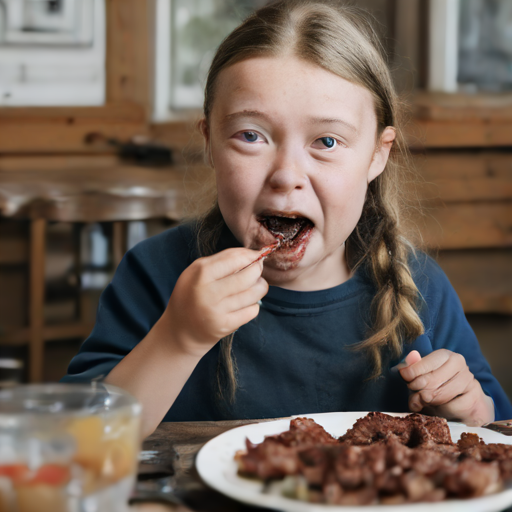

In [6]:
prompt4 = "Greta Tunberg eating meat"

# Передаем prompt в pipe, указываем параметры
# Модель проводит генерацию картинки, соответствующей запросу
image4 = pipe(prompt=prompt4, num_inference_steps=1, guidance_scale=0.0).images[0]
image4

**Вывод:** В данном эксперименте выяснилось что машинка предложенная на лекции для наложения стиля плохо справляется с картинками которые сняты на обычную телефонную камеру (фото кота и стиль голубоглазого самурая) и видно что она пытается не стиль "скопировать" а просто похожие участки перекрасить на такие же. Так же была рассмотрена нейросеть для генерации изображений. Она хорошо справляется с генерации изображений в виде рисунка, но плохо работает с генерацией картин с реальными людьми (рук, глаза)